In [1]:
import os
from pyspark.sql.types import StructField, StructType, StringType, LongType
# from pyspark.sql.functions import to_date, col, year, concat, lit, when, date_add, to_date, add_months, month
from pyspark.sql.functions import *
import random
from pyspark.sql.functions import when, avg
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load Tennessee data
datapath = "gs://pstat235-gy/notebooks/jupyter/final_project/VM2Uniform/VM2Uniform--TN--2021-03-29/VM2Uniform--TN--2021-03-29.tab"

In [3]:
ct_data = spark.read.format("csv")\
.option("inferSchema", "true")\
.option("header", "true")\
.option("delimiter", "\t")\
.csv(datapath)

In [4]:
from pyspark.sql.functions import col, count, when
def drop_null_columns(df, return_dropped_names = False, threshold = 0):
    """
    Function that drops the columns of a dataframe that contain with only a low number of non-null values.
    This number is specified by `threshold`. `threshold = 0` means columns with entirely null values get dropped.
    Optionally returns a list of column names that get dropped.
    """
    not_null_cnt = df.select([count(when(col(c).isNotNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()
    to_drop = [k for k, v in not_null_cnt.items() if v <= threshold]
    if return_dropped_names:
        return df.drop(*to_drop), to_drop
    else:
        return df.drop(*to_drop)

In [5]:
# # for i in ["AnyElection_2010", "AnyElection_2011", "AnyElection_2012"]:
# #     print(ct_data.select(i).distinct().collect())
# # #     print(i)
# # #     print(ct_data.groupBy(i).agg(count("*").alias("count"), (count("*")/ct_data.count()).alias("proportion")))

# for i in ["AnyElection_2010", "AnyElection_2011", "AnyElection_2012"]:
#     ct_data.select([i]).show(10)
i = "General_2012"
ct_data.select(i).distinct().collect()

[Row(General_2012=None), Row(General_2012='Y')]

Compare proportion voted via manual calculation VS OFFICIAL voter turnout figures by county:

In [6]:
# OK, these don't match

ct_data_temp = ct_data.fillna("N", subset = ["General_2012"])
ct_data_temp = ct_data_temp.withColumn("voted_general_2012", when(ct_data_temp.General_2012 == "Y",1)
                             .otherwise(0))
# ct_data_2012_gen = ct_data.select(["ElectionReturns_G12CountyTurnoutAllRegisteredVoters", "voted_general_2012", "County"])
voting_proportion = ct_data_temp.groupBy(['County', "ElectionReturns_G12CountyTurnoutAllRegisteredVoters"])\
    .agg(F.round(F.avg("voted_general_2012"),5)\
    .alias("proportion_voted")).sort(['County'], ascending = False)
voting_proportion.show(50)

+----------+---------------------------------------------------+----------------+
|    County|ElectionReturns_G12CountyTurnoutAllRegisteredVoters|proportion_voted|
+----------+---------------------------------------------------+----------------+
|    WILSON|                                                68%|         0.48472|
|WILLIAMSON|                                                72%|         0.49474|
|     WHITE|                                                56%|         0.47764|
|   WEAKLEY|                                                59%|         0.53515|
|     WAYNE|                                                52%|         0.48623|
|WASHINGTON|                                                63%|         0.48377|
|    WARREN|                                                57%|         0.48877|
| VAN BUREN|                                                50%|          0.4344|
|     UNION|                                                53%|         0.41367|
|    UNICOI|    

23/02/22 00:04:17 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


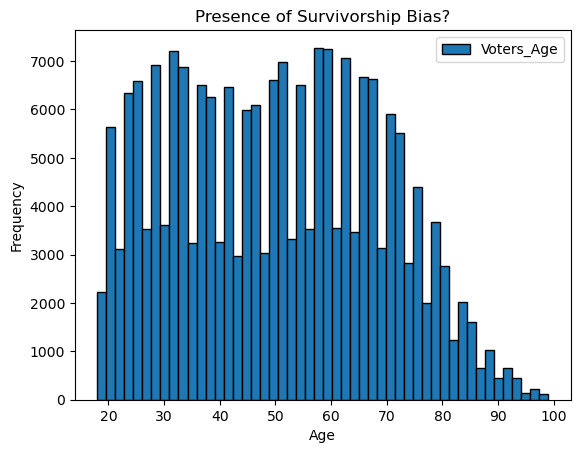

,Voters_BirthDate,year_birth
0,09/02/1960,1960.0
1,09/02/1960,1960.0
2,10/30/1931,1931.0
3,07/19/1986,1986.0
4,11/27/1955,1955.0


In [7]:
# PERHAPS IT'S BECAUSE WE HAVE SURVIVORSHIP BIAS?
# check out the AGE range of the voters

data_pandas = ct_data.sample(True, 0.05, seed = 19480384).toPandas()

data_pandas[["Voters_Age"]].plot(kind = "hist", bins = 50, edgecolor = "black")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Presence of Survivorship Bias?")
plt.show()

data_pandas["year_birth"] = pd.to_datetime(data_pandas["Voters_BirthDate"]).dt.year

data_pandas[["Voters_BirthDate", "year_birth"]].head()

ok, YES. there IS survivorship bias (i.e. the data captures the voters that are CURRENTLY alive, not all previous voters. 
that explains in part the mismatch between the official county level voter participation rates and the manually computed ones.

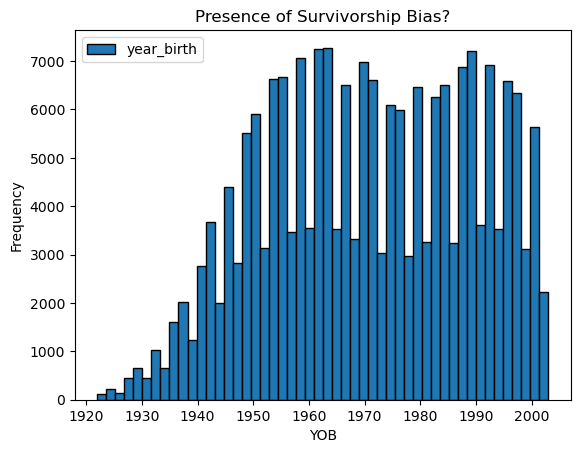

In [8]:
data_pandas[["year_birth"]].plot(kind = "hist", bins = 50, edgecolor = "black")
plt.xlabel("YOB")
plt.ylabel("Frequency")
plt.title("Presence of Survivorship Bias?")
plt.show()

IMPORTANT here to note that we have people BORN in 2000 in this dataset, with "NONE" as their voting behavior
in years 2000 - 2021. We cannot just FILL in "Not voted" for these people.

In [9]:
data_pandas[data_pandas["year_birth"] >= 2000]

,SEQUENCE,LALVOTERID,Voters_Active,Voters_StateVoterID,Voters_CountyVoterID,VoterTelephones_LandlineAreaCode,VoterTelephones_Landline7Digit,VoterTelephones_LandlineFormatted,VoterTelephones_LandlineUnformatted,VoterTelephones_LandlineConfidenceCode,...,PRI_BLT_2008,PRI_BLT_2007,PRI_BLT_2006,PRI_BLT_2005,PRI_BLT_2004,PRI_BLT_2003,PRI_BLT_2002,PRI_BLT_2001,PRI_BLT_2000,year_birth
37,778,LALTN605880844,A,None,1000116730,865.0,494-4099,(865) 494-4099,8.654944e+09,2.0,...,None,None,None,None,None,None,None,None,None,2001.0
111,2705,LALTN540701972,A,None,1000105354,NaN,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,None,2000.0
123,3040,LALTN605879876,A,None,1000115216,NaN,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,None,2002.0
178,3969,LALTN551578829,A,None,1000107621,NaN,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,None,2000.0
245,5263,LALTN572442449,A,None,1000109487,NaN,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,None,2001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203359,4074158,LALTN593914314,A,None,189000175623,615.0,754-9633,(615) 754-9633,6.157550e+09,2.0,...,None,None,None,None,None,None,None,None,None,2002.0
203437,4075941,LALTN551772826,A,None,189000192582,NaN,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,None,2000.0
203445,4076093,LALTN584139083,A,None,189000175041,615.0,773-8487,(615) 773-8487,6.157738e+09,2.0,...,None,None,None,None,None,None,None,None,None,2001.0
203453,4076193,LALTN551783321,A,None,189000166209,NaN,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,None,2000.0


In [ ]:
# drop anything >30% missing & save parquet. 
# NOTE THAT MISSING HERE ALSO SOMETIMES MEANS "no"

# ct, d_cols = drop_null_columns(ct_data, Tdf = spark.read.parquet("TN_parquet")rue, threshold = 0.3)
ct_data.write.format("parquet").save("TN_parquet")

In [3]:
ct_data = spark.read.parquet("TN_parquet")

based on the voter AGE, calculate the DATE at which they turn 18.
make a new variable that is the YEAR of the earliest election that someone COULD participate in
IF the DATE is less than Nov 3rd, take the year at which they turn 18. If the date is greater than Nov 3rd,
get the year afterwards.

In [10]:
yrs_add = 18
months_add = 18*12

# ct_data.withColumn("DATE_18", add_months(to_date(col("Voters_BirthDate")), months_add)).select(["DATE_18"]).show(10)
ct_data = ct_data.withColumn("DATE_18", add_months(to_date(col("Voters_BirthDate"),"MM/dd/yyyy"), months_add))

ct_data.select(["Voters_BirthDate", "DATE_18"]).show(10)

+----------------+----------+
|Voters_BirthDate|   DATE_18|
+----------------+----------+
|      09/02/1960|1978-09-02|
|      01/24/1977|1995-01-24|
|      08/13/1935|1953-08-13|
|      10/30/1931|1949-10-30|
|      02/01/1926|1944-02-01|
|      05/12/1929|1947-05-12|
|      12/13/1939|1957-12-13|
|      04/10/1929|1947-04-10|
|      06/04/1967|1985-06-04|
|      10/10/1968|1986-10-10|
+----------------+----------+
only showing top 10 rows



Check the number of people in our dataset that don't have a birthdate. See if it'll affect our end calculation. Nope.

In [11]:
bday_subset = ct_data.select(["Voters_BirthDate"])
total_count = bday_subset.count()
not_nan_count = bday_subset.dropna().count()
nan_proportion = 1 - not_nan_count / total_count
print(nan_proportion)

0.00023425833076584635


In [12]:
ct_data = ct_data.dropna(subset = "Voters_BirthDate")
ct_data = ct_data.withColumn("YEAR_18", year("DATE_18"))
target_month_day = "11-03"
ct_data = ct_data.withColumn("comparator_date", to_date(concat(col("YEAR_18"), lit("-"), lit(target_month_day))))
ct_data = ct_data.withColumn("YEAR_ELIGIBLE_TO_VOTE", \
                             when(col("DATE_18")<=col("comparator_date"), col("YEAR_18")) \
                             .otherwise(col("YEAR_18") + 1)
                            )

# check no missing vals:
ct_data.where(col("YEAR_18").isNull()).select("YEAR_18").show(10)

+-------+
|YEAR_18|
+-------+
+-------+



In [13]:
bday_subset = ct_data.select(["General_2012"])
total_count = bday_subset.count()
not_nan_count = bday_subset.dropna().count()
nan_proportion = 1 - not_nan_count / total_count
print(nan_proportion)

0.5166285100059106


Recompute the general election voter turnout based on those that were ELIGIBLE to vote at the time:

In [17]:
ct_data_temp = ct_data.filter(col("YEAR_18")<=2012).fillna("N", subset = ["General_2012"])
ct_data_temp = ct_data_temp.select(["General_2012", "ElectionReturns_G12CountyTurnoutAllRegisteredVoters", "County"])
ct_data_temp = ct_data_temp.dropna()
ct_data_temp = ct_data_temp.withColumn("voted_general_2012", when(ct_data_temp.General_2012 == "Y",1).otherwise(0))
voting_proportion = ct_data_temp.groupBy(['County', "ElectionReturns_G12CountyTurnoutAllRegisteredVoters"])\
    .agg(F.round(F.avg("voted_general_2012"),5)\
    .alias("proportion_voted")).sort(['County'], ascending = False)
voting_proportion.show(50)

+----------+---------------------------------------------------+----------------+
|    County|ElectionReturns_G12CountyTurnoutAllRegisteredVoters|proportion_voted|
+----------+---------------------------------------------------+----------------+
|    WILSON|                                                68%|          0.5451|
|WILLIAMSON|                                                72%|         0.56744|
|     WHITE|                                                56%|         0.53194|
|   WEAKLEY|                                                59%|         0.62311|
|     WAYNE|                                                52%|         0.56215|
|WASHINGTON|                                                63%|         0.55126|
|    WARREN|                                                57%|         0.55578|
| VAN BUREN|                                                50%|         0.47384|
|     UNION|                                                53%|         0.45972|
|    UNICOI|    

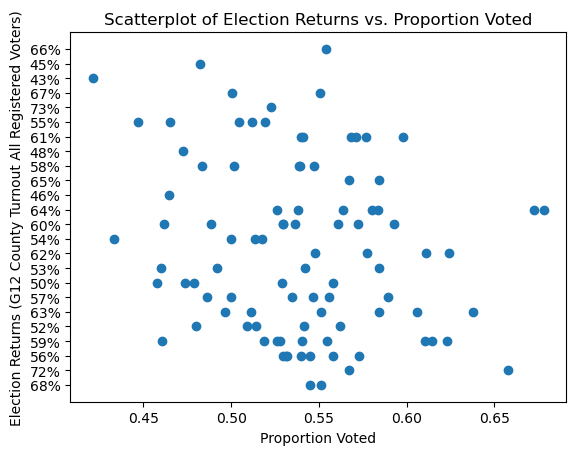

In [16]:
voting_proportion = voting_proportion.toPandas()
plt.scatter(voting_proportion['proportion_voted'], voting_proportion['ElectionReturns_G12CountyTurnoutAllRegisteredVoters'])
plt.xlabel('Proportion Voted')
plt.ylabel('Election Returns (G12 County Turnout All Registered Voters)')
plt.title('Scatterplot of Election Returns vs. Proportion Voted')
plt.show()

Ok, now that we know that, let's continue...

# READ IN FILE

In [44]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ReadParquet").getOrCreate()

df = spark.read.parquet("TN_parquet")

In [45]:
# df = drop_null_columns(df, False, threshold = 0.3)

Get a subset of columns and rows.

In [46]:
# random.seed(78340)
# rand_cols = random.sample(df.columns, k = 30)
# dt = df.select(rand_cols)

In [47]:
columns_starting_with_any_election = [col for col in df.columns if col.startswith("AnyElection")]
columns_starting_with_any_election

bob = df.select(["CommercialData_HomePurchaseDate", 
                 "CommercialData_HomePurchasePrice", 
                 "CommercialDataLL_Interest_in_Tennis_In_Household", 
                 "Residence_HHGender_Description", 
                 "MilitaryStatus_Description", 
                 *columns_starting_with_any_election])

bob.select("CommercialData_HomePurchaseDate").show(10)

+-------------------------------+
|CommercialData_HomePurchaseDate|
+-------------------------------+
|                           null|
|                           null|
|                           null|
|                           null|
|                           null|
|                     04/26/2017|
|                     04/26/2017|
|                     12/03/2012|
|                     08/03/2009|
|                           null|
+-------------------------------+
only showing top 10 rows



In [48]:
sal = bob.sample(True, 0.1, seed = 19480384)
sal.show(10)

+-------------------------------+--------------------------------+------------------------------------------------+------------------------------+--------------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+
|CommercialData_HomePurchaseDate|CommercialData_HomePurchasePrice|CommercialDataLL_Interest_in_Tennis_In_Household|Residence_HHGender_Description|MilitaryStatus_Description|AnyElection_2021|AnyElection_2019|AnyElection_2017|AnyElection_2015|AnyElection_2013|AnyElection_2011|AnyElection_2009|AnyElection_2007|AnyElection_2005|AnyElection_2003|AnyElection_2001|
+-------------------------------+--------------------------------+------------------------------------------------+------------------------------+--------------------------+----------------+----------------+----------------+----------------+----------------+----------------+---

In [49]:
sal.write.format("parquet").save("TN_parquet_subset")

In [50]:
sal = spark.read.parquet("TN_parquet_subset")

In [ ]:
for i in sal.columns:
    print(sal.select(i).distinct().collect())

Replace NULL/EMPTY values with "N"

In [52]:
sal = sal.fillna("N", subset = [col for col in sal.columns if sal.select(col).dtypes[0][1] == "string"])

In [53]:
sal.printSchema()

root
 |-- CommercialData_HomePurchaseDate: string (nullable = false)
 |-- CommercialData_HomePurchasePrice: string (nullable = false)
 |-- CommercialDataLL_Interest_in_Tennis_In_Household: string (nullable = false)
 |-- Residence_HHGender_Description: string (nullable = false)
 |-- MilitaryStatus_Description: string (nullable = false)
 |-- AnyElection_2021: string (nullable = false)
 |-- AnyElection_2019: string (nullable = false)
 |-- AnyElection_2017: string (nullable = false)
 |-- AnyElection_2015: string (nullable = false)
 |-- AnyElection_2013: string (nullable = false)
 |-- AnyElection_2011: string (nullable = false)
 |-- AnyElection_2009: string (nullable = false)
 |-- AnyElection_2007: string (nullable = false)
 |-- AnyElection_2005: string (nullable = false)
 |-- AnyElection_2003: string (nullable = false)
 |-- AnyElection_2001: string (nullable = false)



In [54]:
sal.select("CommercialData_HomePurchasePrice").head(30)

[Row(CommercialData_HomePurchasePrice='$345000'),
 Row(CommercialData_HomePurchasePrice='$453000'),
 Row(CommercialData_HomePurchasePrice='$453000'),
 Row(CommercialData_HomePurchasePrice='$306000'),
 Row(CommercialData_HomePurchasePrice='$363000'),
 Row(CommercialData_HomePurchasePrice='$165000'),
 Row(CommercialData_HomePurchasePrice='$275000'),
 Row(CommercialData_HomePurchasePrice='N'),
 Row(CommercialData_HomePurchasePrice='$355000'),
 Row(CommercialData_HomePurchasePrice='$355000'),
 Row(CommercialData_HomePurchasePrice='$441000'),
 Row(CommercialData_HomePurchasePrice='$78000'),
 Row(CommercialData_HomePurchasePrice='$325000'),
 Row(CommercialData_HomePurchasePrice='N'),
 Row(CommercialData_HomePurchasePrice='N'),
 Row(CommercialData_HomePurchasePrice='N'),
 Row(CommercialData_HomePurchasePrice='N'),
 Row(CommercialData_HomePurchasePrice='N'),
 Row(CommercialData_HomePurchasePrice='N'),
 Row(CommercialData_HomePurchasePrice='N'),
 Row(CommercialData_HomePurchasePrice='N'),
 Row(

In [55]:
sal = sal.withColumn("CommercialData_HomePurchasePrice", 
                   F.when(F.col("CommercialData_HomePurchasePrice").isin("N", ""), F.lit(None)).otherwise(
                   F.regexp_replace(F.col("CommercialData_HomePurchasePrice"), "\$", "").cast("double")))

In [56]:
for yr in list(range(2001,2023,2)):
    sal.filter(col("CommercialData_HomePurchasePrice").isNotNull())\
    .groupBy(f'AnyElection_{yr}')\
    .agg(F.round(F.avg("CommercialData_HomePurchasePrice"),1)\
    .alias("Home Purchase Price")).show()

+----------------+-------------------+
|AnyElection_2001|Home Purchase Price|
+----------------+-------------------+
|               Y|           151235.8|
|               N|           207151.8|
+----------------+-------------------+



+----------------+-------------------+
|AnyElection_2003|Home Purchase Price|
+----------------+-------------------+
|               Y|           181859.3|
|               N|           207077.7|
+----------------+-------------------+

+----------------+-------------------+
|AnyElection_2005|Home Purchase Price|
+----------------+-------------------+
|               Y|           186745.5|
|               N|           206713.2|
+----------------+-------------------+



+----------------+-------------------+
|AnyElection_2007|Home Purchase Price|
+----------------+-------------------+
|               Y|           201393.7|
|               N|           206419.6|
+----------------+-------------------+

+----------------+-------------------+
|AnyElection_2009|Home Purchase Price|
+----------------+-------------------+
|               Y|           199424.0|
|               N|           206503.2|
+----------------+-------------------+

+----------------+-------------------+
|AnyElection_2011|Home Purchase Price|
+----------------+-------------------+
|               Y|           192994.1|
|               N|           206766.9|
+----------------+-------------------+

+----------------+-------------------+
|AnyElection_2013|Home Purchase Price|
+----------------+-------------------+
|               Y|           206807.1|
|               N|           206081.9|
+----------------+-------------------+

+----------------+-------------------+
|AnyElection_2015|Hom

In [57]:
sal = sal.withColumn("CommercialData_HomePurchaseDate", to_date(col("CommercialData_HomePurchaseDate"), "MM/dd/yyy"))

In [58]:
sal = sal.withColumn("year_bought_house", year(col("CommercialData_HomePurchaseDate")))

In [59]:
sal.printSchema()

root
 |-- CommercialData_HomePurchaseDate: date (nullable = true)
 |-- CommercialData_HomePurchasePrice: double (nullable = true)
 |-- CommercialDataLL_Interest_in_Tennis_In_Household: string (nullable = false)
 |-- Residence_HHGender_Description: string (nullable = false)
 |-- MilitaryStatus_Description: string (nullable = false)
 |-- AnyElection_2021: string (nullable = false)
 |-- AnyElection_2019: string (nullable = false)
 |-- AnyElection_2017: string (nullable = false)
 |-- AnyElection_2015: string (nullable = false)
 |-- AnyElection_2013: string (nullable = false)
 |-- AnyElection_2011: string (nullable = false)
 |-- AnyElection_2009: string (nullable = false)
 |-- AnyElection_2007: string (nullable = false)
 |-- AnyElection_2005: string (nullable = false)
 |-- AnyElection_2003: string (nullable = false)
 |-- AnyElection_2001: string (nullable = false)
 |-- year_bought_house: integer (nullable = true)



In [60]:
from pyspark.sql.functions import col, expr

# Select the necessary columns
df_selected = sal.select(col("year_bought_house"), 
                col("CommercialData_HomePurchasePrice"), 
                col("CommercialDataLL_Interest_in_Tennis_In_Household"),
                col("Residence_HHGender_Description"),
                col("MilitaryStatus_Description"),
                col("AnyElection_2021"), col("AnyElection_2019"), 
                col("AnyElection_2017"), col("AnyElection_2015"), 
                col("AnyElection_2013"), col("AnyElection_2011"), 
                col("AnyElection_2009"), col("AnyElection_2007"), 
                col("AnyElection_2005"), col("AnyElection_2003"), 
                col("AnyElection_2001"))

df_long = df_selected.select(
    expr("""stack(11, 
                2021, AnyElection_2021,
                2019, AnyElection_2019,
                2017, AnyElection_2017,
                2015, AnyElection_2015,
                2013, AnyElection_2013,
                2011, AnyElection_2011,
                2009, AnyElection_2009,
                2007, AnyElection_2007,
                2005, AnyElection_2005,
                2003, AnyElection_2003,
                2001, AnyElection_2001)
                as (year, voted)"""),
            col("year_bought_house"),
            col("CommercialData_HomePurchasePrice").alias("purchase_price"),
            col("CommercialDataLL_Interest_in_Tennis_In_Household").alias("tennis"),
            col("Residence_HHGender_Description").alias("hh_gender"),
            col("MilitaryStatus_Description").alias("military"))
df_long.show(10)

+----+-----+-----------------+--------------+------+--------------------+--------+
|year|voted|year_bought_house|purchase_price|tennis|           hh_gender|military|
+----+-----+-----------------+--------------+------+--------------------+--------+
|2021|    N|             2016|      345000.0|     N|Mixed Gender Hous...|       N|
|2019|    Y|             2016|      345000.0|     N|Mixed Gender Hous...|       N|
|2017|    N|             2016|      345000.0|     N|Mixed Gender Hous...|       N|
|2015|    N|             2016|      345000.0|     N|Mixed Gender Hous...|       N|
|2013|    Y|             2016|      345000.0|     N|Mixed Gender Hous...|       N|
|2011|    N|             2016|      345000.0|     N|Mixed Gender Hous...|       N|
|2009|    Y|             2016|      345000.0|     N|Mixed Gender Hous...|       N|
|2007|    N|             2016|      345000.0|     N|Mixed Gender Hous...|       N|
|2005|    N|             2016|      345000.0|     N|Mixed Gender Hous...|       N|
|200

In [61]:
df_long = df_long.withColumn("contemp_home_ownership", col("year_bought_house")<=col("year"))
df_long.filter(col("contemp_home_ownership").isNotNull()).show(10)

+----+-----+-----------------+--------------+------+--------------------+--------+----------------------+
|year|voted|year_bought_house|purchase_price|tennis|           hh_gender|military|contemp_home_ownership|
+----+-----+-----------------+--------------+------+--------------------+--------+----------------------+
|2021|    N|             2016|      345000.0|     N|Mixed Gender Hous...|       N|                  true|
|2019|    Y|             2016|      345000.0|     N|Mixed Gender Hous...|       N|                  true|
|2017|    N|             2016|      345000.0|     N|Mixed Gender Hous...|       N|                  true|
|2015|    N|             2016|      345000.0|     N|Mixed Gender Hous...|       N|                 false|
|2013|    Y|             2016|      345000.0|     N|Mixed Gender Hous...|       N|                 false|
|2011|    N|             2016|      345000.0|     N|Mixed Gender Hous...|       N|                 false|
|2009|    Y|             2016|      345000.0| 

In [62]:
# voter turnout across time (proportion of those who vote) by household composition, and at-the-time home ownership:

df_long = df_long.fillna(False, subset = ["contemp_home_ownership"])
df_long = df_long.withColumn("voted_numeric", when(df_long.voted == "Y",1)
                             .otherwise(0))

In [63]:
tab_voter_turnout_home_ownership_proportion = df_long.groupBy(['year','hh_gender','contemp_home_ownership'])\
    .agg(F.round(F.avg("voted_numeric"),5)\
    .alias("proportion_voted")).sort(['year','contemp_home_ownership','hh_gender'], ascending = False)

tab_voter_turnout_home_ownership_proportion.show(500)

+----+--------------------+----------------------+----------------+
|year|           hh_gender|contemp_home_ownership|proportion_voted|
+----+--------------------+----------------------+----------------+
|2021|Mixed Gender Hous...|                  true|             0.0|
|2021| Male Only Household|                  true|             0.0|
|2021|Female Only House...|                  true|             0.0|
|2021|    Cannot Determine|                  true|             0.0|
|2021|Mixed Gender Hous...|                 false|             0.0|
|2021| Male Only Household|                 false|             0.0|
|2021|Female Only House...|                 false|             0.0|
|2021|    Cannot Determine|                 false|             0.0|
|2019|Mixed Gender Hous...|                  true|         0.08378|
|2019| Male Only Household|                  true|         0.08227|
|2019|Female Only House...|                  true|         0.09783|
|2019|    Cannot Determine|                  tru

In [64]:
df_long.filter((col("tennis") == "Yes") & (col("military") == "Military")).show(100)
df.filter((col("CommercialDataLL_Interest_in_Tennis_In_Household") == "Yes") & (col("MilitaryStatus_Description") == "Military")).count()
df.filter((col("CommercialDataLL_Interest_in_Fishing_In_Household") == "Yes") & (col("MilitaryStatus_Description") == "Military")).count()
df.filter((col("CommercialDataLL_Investor") == "Yes") & (col("CommercialDataLL_Veteran") == "Yes")).count()
df.filter((col("CommercialDataLL_Interest_in_Tennis_In_Household") == "Yes") & (col("CommercialDataLL_Veteran") == "Yes")).count()

+----+-----+-----------------+--------------+------+---------+--------+----------------------+-------------+
|year|voted|year_bought_house|purchase_price|tennis|hh_gender|military|contemp_home_ownership|voted_numeric|
+----+-----+-----------------+--------------+------+---------+--------+----------------------+-------------+
+----+-----+-----------------+--------------+------+---------+--------+----------------------+-------------+



2772

+----+------+--------+----------------+
|year|tennis|military|proportion_voted|
+----+------+--------+----------------+
|2021|   Yes|Civilian|             0.0|
|2021|    No|Civilian|             0.0|
|2019|   Yes|Civilian|         0.10233|
|2019|    No|Civilian|         0.07795|
|2017|   Yes|Civilian|         0.03315|
|2017|    No|Civilian|         0.01899|
|2015|   Yes|Civilian|         0.08994|
|2015|    No|Civilian|         0.06195|
|2013|   Yes|Civilian|         0.04728|
|2013|    No|Civilian|         0.02892|
|2011|   Yes|Civilian|         0.07408|
|2011|    No|Civilian|         0.04842|
|2009|   Yes|Civilian|         0.08792|
|2009|    No|Civilian|         0.05629|
|2007|   Yes|Civilian|         0.09743|
|2007|    No|Civilian|         0.06393|
|2005|   Yes|Civilian|         0.05477|
|2005|    No|Civilian|         0.03112|
|2003|   Yes|Civilian|         0.06601|
|2003|    No|Civilian|         0.04201|
|2001|   Yes|Civilian|         0.03805|
|2001|    No|Civilian|         0.02037|


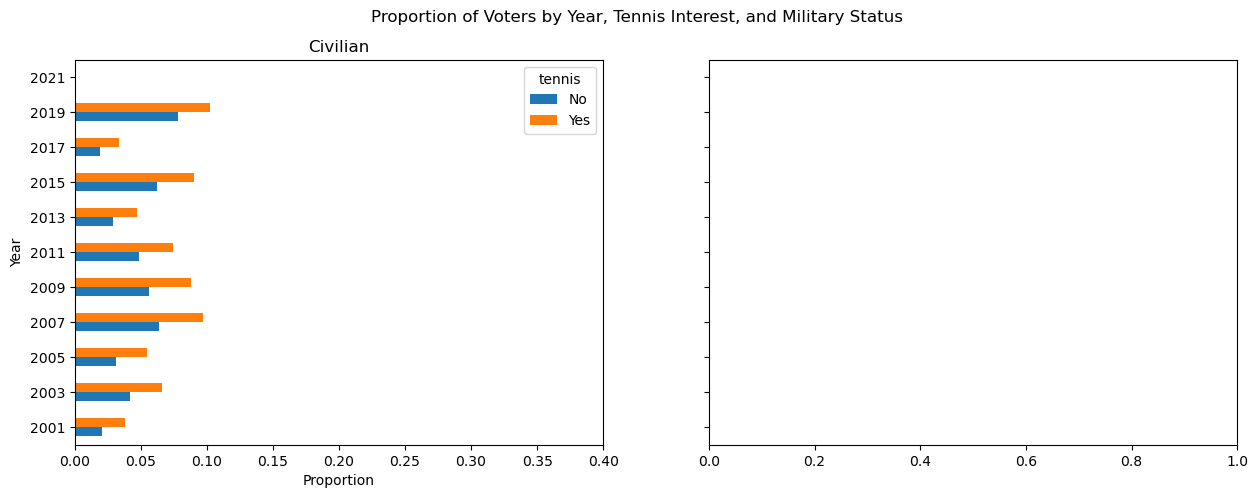

In [65]:
tab_tennis_military = df_long.groupBy(['year','tennis','military'])\
    .agg(F.round(F.avg("voted_numeric"),5)\
    .alias("proportion_voted")).sort(['year','tennis','military'], ascending = False)

tab_tennis_military = tab_tennis_military.withColumn("military", when(tab_tennis_military.military == "N", "Civilian").otherwise(tab_tennis_military.military))
tab_tennis_military = tab_tennis_military.withColumn("tennis", when(tab_tennis_military.tennis == "N", "No").otherwise(tab_tennis_military.tennis))

tab_tennis_military.show(500)

data_pandas = tab_tennis_military.toPandas()

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5), sharey = True)

for i, gender in enumerate(data_pandas["military"].unique()):
    data_pandas[data_pandas["military"] == gender].pivot_table(index = ["year"], columns = "tennis", values = "proportion_voted").plot(kind = "barh", ax = axs[i])
    axs[i].set_xlabel("Proportion")
    axs[i].set_ylabel("Year")
    axs[i].set_title(f"{gender}")
    axs[i].set_xlim([0, 0.4])
    
plt.suptitle("Proportion of Voters by Year, Tennis Interest, and Military Status")
plt.show()

# seems like commercial data doesn't sample those actively in the military:

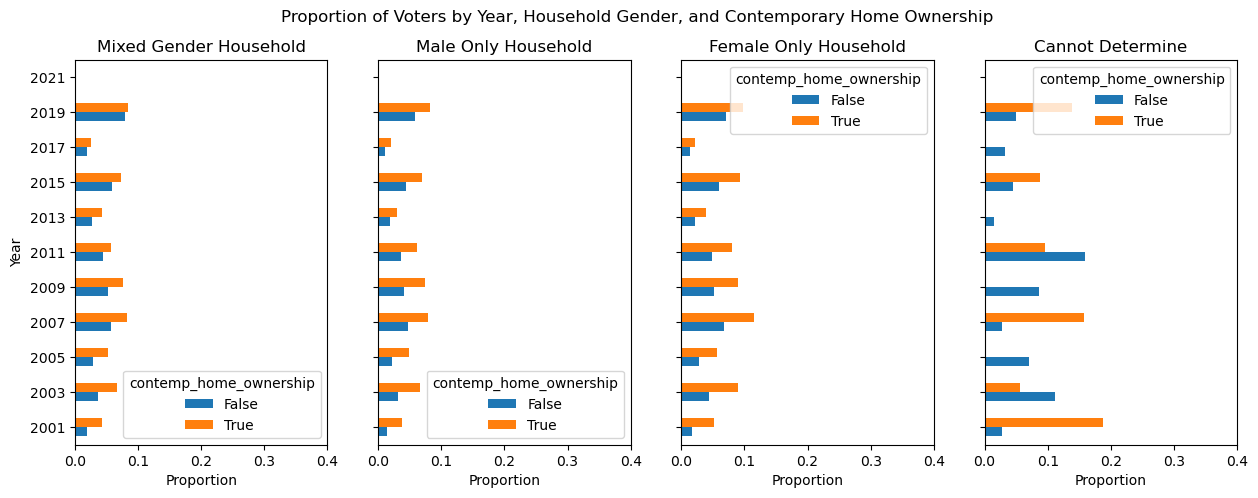

In [66]:
data_pandas = tab_voter_turnout_home_ownership_proportion.toPandas()

fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 5), sharey = True)

for i, gender in enumerate(data_pandas["hh_gender"].unique()):
    data_pandas[data_pandas["hh_gender"] == gender].pivot_table(index = ["year"], columns = "contemp_home_ownership", values = "proportion_voted").plot(kind = "barh", ax = axs[i])
    axs[i].set_xlabel("Proportion")
    axs[i].set_ylabel("Year")
    axs[i].set_title(f"{gender}")
    axs[i].set_xlim([0, 0.4])
    
plt.suptitle("Proportion of Voters by Year, Household Gender, and Contemporary Home Ownership")
plt.show()
    
# ENTIRE PLOT
# data_pandas.pivot_table(index=["year", "hh_gender"], columns="contemp_home_ownership", values="proportion_voted").plot(kind="barh", figsize = (8,12))
# plt.xlabel("Proportion")
# plt.title("Proportion of Voters by Year, Household Gender, and Contemporary Home Ownership")
# plt.show()

# perhaps I'm just capturing the effect of age here?
# secular trend of increased voter turnout across time
# the GAP in voter turnout among mixed gender households by contemporary home ownership (presumably married) has decreased

+----+------+----------------------+----------------+
|year|tennis|contemp_home_ownership|proportion_voted|
+----+------+----------------------+----------------+
|2021|   Yes|                  true|             0.0|
|2021|   Yes|                 false|             0.0|
|2021|    No|                  true|             0.0|
|2021|    No|                 false|             0.0|
|2019|   Yes|                  true|         0.09814|
|2019|   Yes|                 false|         0.10623|
|2019|    No|                  true|         0.08561|
|2019|    No|                 false|         0.07266|
|2017|   Yes|                  true|         0.03373|
|2017|   Yes|                 false|          0.0327|
|2017|    No|                  true|         0.02477|
|2017|    No|                 false|         0.01584|
|2015|   Yes|                  true|         0.08951|
|2015|   Yes|                 false|         0.09022|
|2015|    No|                  true|         0.07515|
|2015|    No|               

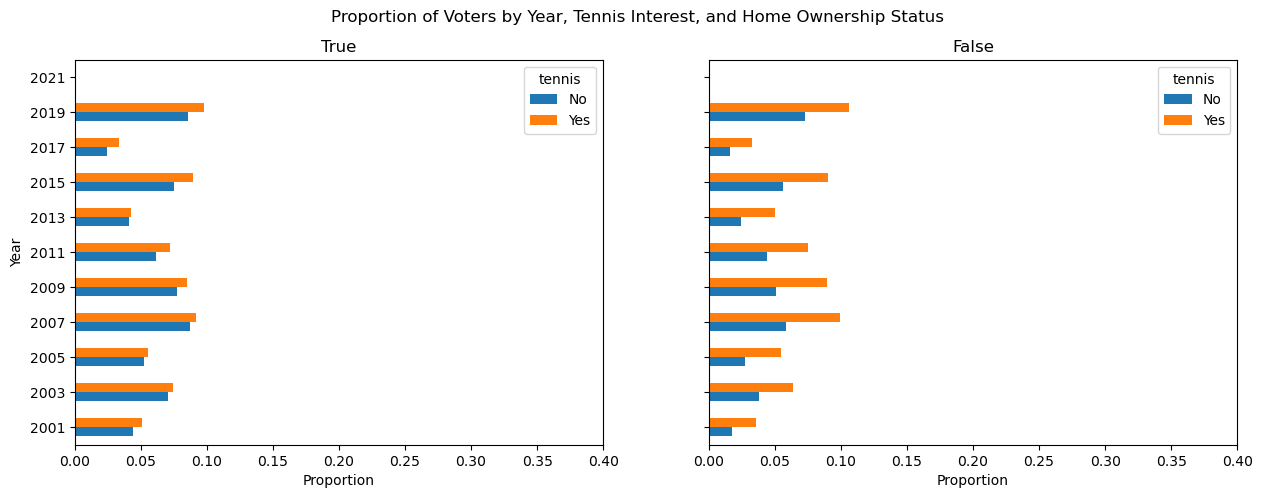

In [67]:
tab_tennis_home = df_long.groupBy(['year','tennis','contemp_home_ownership'])\
    .agg(F.round(F.avg("voted_numeric"),5)\
    .alias("proportion_voted")).sort(['year','tennis','contemp_home_ownership'], ascending = False)

tab_tennis_home = tab_tennis_home.withColumn("tennis", when(tab_tennis_home.tennis == "N", "No").otherwise(tab_tennis_home.tennis))

tab_tennis_home.show(500)

data_pandas = tab_tennis_home.toPandas()

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5), sharey = True)

for i, gender in enumerate(data_pandas["contemp_home_ownership"].unique()):
    data_pandas[data_pandas["contemp_home_ownership"] == gender].pivot_table(index = ["year"], columns = "tennis", values = "proportion_voted").plot(kind = "barh", ax = axs[i])
    axs[i].set_xlabel("Proportion")
    axs[i].set_ylabel("Year")
    axs[i].set_title(f"{gender}")
    axs[i].set_xlim([0, 0.4])
    
plt.suptitle("Proportion of Voters by Year, Tennis Interest, and Home Ownership Status")
plt.show()

+----+--------+----------------------+----------------+
|year|military|contemp_home_ownership|proportion_voted|
+----+--------+----------------------+----------------+
|2021|Civilian|                  true|             0.0|
|2021|Civilian|                 false|             0.0|
|2019|Civilian|                  true|         0.08573|
|2019|Civilian|                 false|         0.07291|
|2017|Civilian|                  true|         0.02487|
|2017|Civilian|                 false|         0.01597|
|2015|Civilian|                  true|         0.07531|
|2015|Civilian|                 false|          0.0565|
|2013|Civilian|                  true|         0.04085|
|2013|Civilian|                 false|         0.02484|
|2011|Civilian|                  true|         0.06184|
|2011|Civilian|                 false|         0.04455|
|2009|Civilian|                  true|         0.07776|
|2009|Civilian|                 false|         0.05075|
|2007|Civilian|                  true|         0

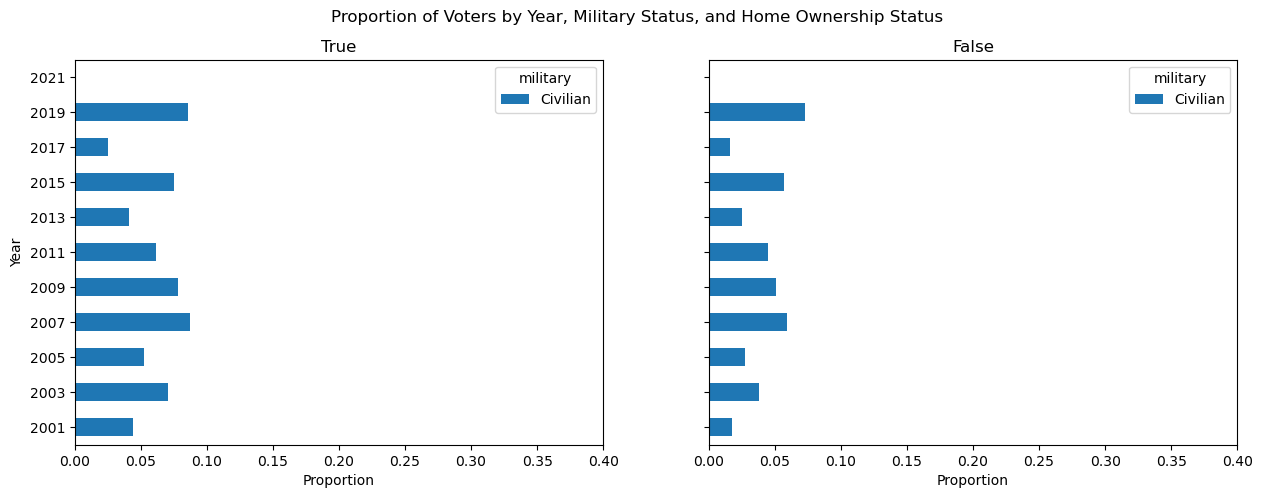

In [68]:
tab_military_home = df_long.groupBy(['year','military','contemp_home_ownership'])\
    .agg(F.round(F.avg("voted_numeric"),5)\
    .alias("proportion_voted")).sort(['year','military','contemp_home_ownership'], ascending = False)

tab_military_home = tab_military_home.withColumn("military", when(tab_military_home.military == "N", "Civilian").otherwise(tab_military_home.military))

tab_military_home.show(500)

data_pandas = tab_military_home.toPandas()

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5), sharey = True)

for i, gender in enumerate(data_pandas["contemp_home_ownership"].unique()):
    data_pandas[data_pandas["contemp_home_ownership"] == gender].pivot_table(index = ["year"], columns = "military", values = "proportion_voted").plot(kind = "barh", ax = axs[i])
    axs[i].set_xlabel("Proportion")
    axs[i].set_ylabel("Year")
    axs[i].set_title(f"{gender}")
    axs[i].set_xlim([0, 0.4])
    
plt.suptitle("Proportion of Voters by Year, Military Status, and Home Ownership Status")
plt.show()

In [69]:
# see if purchase price is inflation adjusted (NOT INFLATION ADJUSTED):

df_long.filter(col("purchase_price").isNotNull()).groupBy("year_bought_house").agg(F.avg("purchase_price")).sort("year_bought_house").show(50)

+-----------------+-------------------+
|year_bought_house|avg(purchase_price)|
+-----------------+-------------------+
|             1900|           317000.0|
|             1965|            20000.0|
|             1966|            20000.0|
|             1969|            28000.0|
|             1971|            46000.0|
|             1972| 23333.333333333332|
|             1973|            24000.0|
|             1974|            33750.0|
|             1975| 32222.222222222223|
|             1976| 27916.666666666668|
|             1977|  45423.07692307692|
|             1978|            36375.0|
|             1979|  48861.11111111111|
|             1980|  52151.51515151515|
|             1981|            59400.0|
|             1982|  52837.20930232558|
|             1983|  46890.90909090909|
|             1984|            50000.0|
|             1985|         57007.8125|
|             1986|  54848.31460674157|
|             1987|  72670.78189300411|
|             1988|   68486.8154158215|


In [70]:
df_long.show(10)

+----+-----+-----------------+--------------+------+--------------------+--------+----------------------+-------------+
|year|voted|year_bought_house|purchase_price|tennis|           hh_gender|military|contemp_home_ownership|voted_numeric|
+----+-----+-----------------+--------------+------+--------------------+--------+----------------------+-------------+
|2021|    N|             2016|      345000.0|     N|Mixed Gender Hous...|       N|                  true|            0|
|2019|    Y|             2016|      345000.0|     N|Mixed Gender Hous...|       N|                  true|            1|
|2017|    N|             2016|      345000.0|     N|Mixed Gender Hous...|       N|                  true|            0|
|2015|    N|             2016|      345000.0|     N|Mixed Gender Hous...|       N|                 false|            0|
|2013|    Y|             2016|      345000.0|     N|Mixed Gender Hous...|       N|                 false|            1|
|2011|    N|             2016|      3450